In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
tf.__version__

'2.1.0-dev20200105'

# Test scaling for simple 1-D Hamiltonian o  

In [3]:
def create_hamiltonian(n = 32):
    t0_var = tf.Variable(1.0)    
    
    @tf.function
    def _fn():
        U = np.eye(n).astype(np.complex64)
        T = np.eye(n, k=-1).astype(np.complex64) * 1j
        t0 = tf.complex(t0_var, 0.0)        
        Th = tf.convert_to_tensor(np.conjugate(T).T)
        H = - t0 * T - t0 * Th + 2 * t0 * U
        return H
    
    return _fn, [t0_var]

In [4]:
@tf.function
def compute_gradients(num_evals, hamiltonian_fn, hamiltonian_small_fn):
    with tf.GradientTape() as tape:
        H = hamiltonian_fn()
        evals, evecs = tf.linalg.eigh(H)

        H_small = hamiltonian_small_fn()
        evals_small, evecs_small = tf.linalg.eigh(H_small)

        delta2 = tf.square(evals_small[:num_evals] - evals[:num_evals])
        loss = tf.reduce_mean(delta2)
        loss = tf.math.real(loss)
        
        gradients = tape.gradient(loss, h_params_small)
    return loss, gradients


num_evals = 1
n  = 32
hamiltonian_fn, h_params = create_hamiltonian(n = n)
hamiltonian_small_fn, h_params_small = create_hamiltonian(n = n // 2)

optimizer = tf.keras.optimizers.Adam(0.01, epsilon=0.0001)
loss_history = []
param_hist = []

In [5]:
for i in tqdm(range(500)):
    loss, gradients = compute_gradients(num_evals, hamiltonian_fn, hamiltonian_small_fn)
    optimizer.apply_gradients(zip(gradients, h_params_small))
    loss_history.append(loss.numpy())
    param_hist.append(h_params_small[0].numpy())

100%|██████████| 500/500 [00:01<00:00, 284.80it/s]


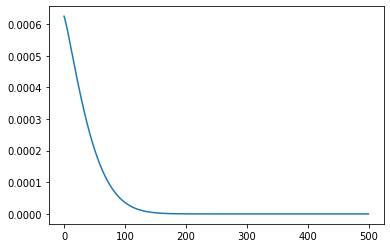

In [6]:
plt.plot(loss_history)

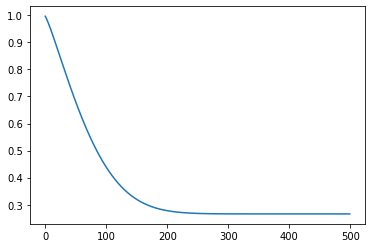

In [7]:
plt.plot(param_hist)

In [8]:
H = hamiltonian_fn()
evals, evecs = tf.linalg.eigh(H)
evals[:4].numpy()

array([0.00905614+0.j, 0.03614271+0.j, 0.08101411+0.j, 0.14326431+0.j],
      dtype=complex64)

In [9]:
H = hamiltonian_small_fn()
evals, evecs = tf.linalg.eigh(H)
evals[:4].numpy()

array([0.00905613+0.j, 0.03591586+0.j, 0.07966478+0.j, 0.13881284+0.j],
      dtype=complex64)

In [10]:
h_params_small

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.26593393>]

## Compare eigenvalues of original and scalled lattices

/home/mkk/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 1.25)

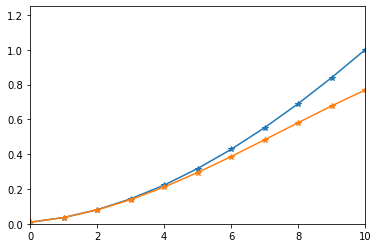

In [11]:
H = hamiltonian_fn()
evals, _ = tf.linalg.eigh(H)
H = hamiltonian_small_fn()
evals_small, _ = tf.linalg.eigh(H)

plt.plot(evals.numpy(), '*-')
plt.plot(evals_small.numpy(), '*-')
plt.xlim([0, 10])
plt.ylim([0, 1.25])

# Scaling for graphene 

In [12]:
from scipy.spatial import KDTree

def create_lattice(nx, ny):
    
    v1 = np.array([np.sqrt(3) / 2, - 1 / 2])
    v2 = np.array([0, 1.0])
    a1 = np.array([1/np.sqrt(3), 0.0])
    a2 = np.array([1/np.sqrt(3)/2, 1 / 2])
    max_dist = 0.6
    atoms = [a1, a2]
    
    lattice_atoms = []
    for i in range(nx):
        for j in range(ny):
            for a in atoms:
                pos = a + i * v1 + (j + i//2) * v2
                lattice_atoms.append(pos)
    
    neighbors_distances, neighbors_indices = KDTree(lattice_atoms).query(lattice_atoms, k=4)
    new_atoms = []
    for k, (nnds, nnis) in enumerate(zip(neighbors_distances, neighbors_indices)):
        if len([nnd for nnd in nnds if nnd < max_dist]) > 2:
            new_atoms.append(lattice_atoms[k])
    lattice_atoms = new_atoms
    
    neighbors_distances, neighbors_indices = KDTree(lattice_atoms).query(lattice_atoms, k=4)
    n = len(lattice_atoms)
    U = np.zeros([n, n])
    T = np.zeros([n, n])
    
    
    for k, (nnds, nnis) in enumerate(zip(neighbors_distances, neighbors_indices)):
        for nnd, nni in zip(nnds, nnis):
            if nnd > max_dist:
                break
            if k == nni:
                continue
            T[k, nni] = 1.0
    
    return np.array(lattice_atoms), U, T

## Plotting created lattice, unit cell and coupling between cells

39.0


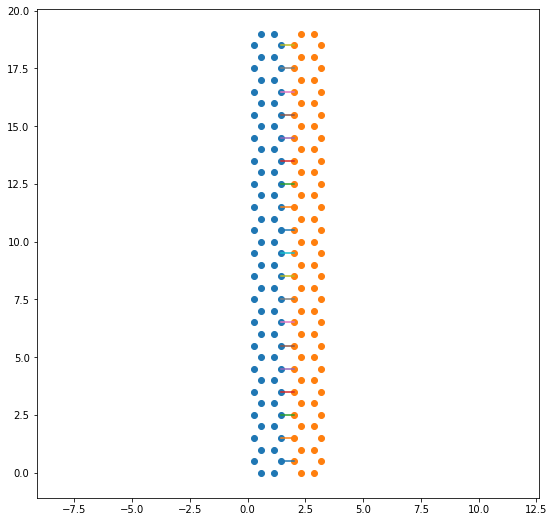

In [14]:
lattice_atoms, U, T = create_lattice(2, 20)
second_cell = lattice_atoms + np.array([[np.sqrt(3), 0]])

print(len(lattice_atoms) / 2)

neighbors_distances, neighbors_indices = KDTree(lattice_atoms).query(second_cell, k=2)
max_dist = 0.6
n = len(lattice_atoms)
Cp = np.zeros([n, n])

for k, (nnds, nnis) in enumerate(zip(neighbors_distances, neighbors_indices)):
    for nnd, nni in zip(nnds, nnis):
        if nnd > max_dist:
            break
        Cp[k, nni] = 1.0

Cp = Cp.T
        
plt.figure(figsize=(9, 9))
plt.scatter(*np.array(lattice_atoms).T)
plt.scatter(*np.array(second_cell).T)
for i, row in enumerate(Cp):
    if row.max() == 0:
        continue
    j = row.argmax()
    xi, yi = lattice_atoms[i]
    xj, yj = second_cell[j]
    plt.plot([xi, xj], [yi, yj], '-')
    
_ = plt.axis("equal")

In [15]:
def create_hamiltonian(n = 10, t0_init = 1.0, a0_init = 1.0):
    t0_var = tf.Variable(t0_init)
    a0_var = tf.Variable(a0_init)
    dtype = tf.complex64
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.float32)])
    def _fn(kvec):
        lattice_atoms, U, T = create_lattice(2, n)
        second_cell = lattice_atoms + np.array([[np.sqrt(3), 0]])

        neighbors_distances, neighbors_indices = KDTree(lattice_atoms).query(second_cell, k=2)
        max_dist = 0.6
        ns = len(lattice_atoms)
        Cp = np.zeros([ns, ns])

        for k, (nnds, nnis) in enumerate(zip(neighbors_distances, neighbors_indices)):
            for nnd, nni in zip(nnds, nnis):
                if nnd > max_dist:
                    break
                Cp[k, nni] = 1.0

        Cp = Cp.T
        t0 = tf.complex(t0_var, 0.0)
        U = tf.convert_to_tensor(U, dtype=dtype)
        T = tf.convert_to_tensor(T, dtype=dtype)
        H = U + t0 * T
        
        phase = tf.exp(-tf.complex(0.0, a0_var * kvec))
        S = t0 * phase * tf.convert_to_tensor(Cp, dtype=dtype)
        S_h = tf.math.conj(tf.transpose(S))        
        
        return H + S + S_h
    
    return _fn, [t0_var, a0_var]

In [16]:
@tf.function
def compute_gradients(
    num_evals, hamiltonian_fn, hamiltonian_small_fn, h_params_small, batch_size = 4, kvec_scale=0.2
):
    with tf.GradientTape() as tape:
        losses = []
        for _ in range(batch_size):
            kvec = tf.random.uniform([], minval=-kvec_scale, maxval=kvec_scale)
            H = hamiltonian_fn(kvec=kvec)
            evals, evecs = tf.linalg.eigh(H)

            hs = evals.shape.as_list()[0] // 2
            e1 = evals[hs-num_evals:hs+num_evals]
            e1 = tf.math.real(e1)

            H_small = hamiltonian_small_fn(kvec=kvec)
            evals_small, evecs_small = tf.linalg.eigh(H_small)

            hs = evals_small.shape.as_list()[0] // 2
            e2 = evals_small[hs-num_evals:hs+num_evals]
            e2 = tf.math.real(e2)
            loss = tf.square(e1 - e2)
            loss = tf.reduce_mean(loss)
            losses.append(loss)
            
        loss = tf.reduce_mean(losses)
        gradients = tape.gradient(loss, h_params_small)
                
        
    return loss, gradients

In [17]:
num_evals = 2
n = 30
hamiltonian_fn, h_params = create_hamiltonian(n = n)
hamiltonian_small_fn, h_params_small = create_hamiltonian(n = n // 2, a0_init=1.0, t0_init=1.0)

optimizer = tf.keras.optimizers.Adam(0.1, beta_1=0.9, beta_2=0.995, epsilon=0.0001)
loss_history = []
param_hist = []
param_hist2 = []

In [18]:
loss, gradients = compute_gradients(num_evals, hamiltonian_fn, hamiltonian_small_fn, h_params_small)

Cause: mangled names are not yet supported by AutoGraph
Cause: mangled names are not yet supported by AutoGraph


In [19]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=0.014945317>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.001837404>]

In [20]:
H = hamiltonian_fn(0.0)
evals, _ = tf.linalg.eigh(H)
hs = evals.shape.as_list()[0] // 2
evals[hs-num_evals:hs+num_evals]
# _ = hamiltonian_small_fn(0.0)

<tf.Tensor: shape=(4,), dtype=complex64, numpy=
array([-8.9278042e-02+0.j, -4.1837112e-08+0.j,  4.1827736e-08+0.j,
        8.9277968e-02+0.j], dtype=complex64)>

In [21]:
H = hamiltonian_small_fn(0.0)
evals, evecs = tf.linalg.eigh(H)
hs = evals.shape.as_list()[0] // 2
evals[hs-num_evals:hs+num_evals]

<tf.Tensor: shape=(4,), dtype=complex64, numpy=
array([-1.7557065e-01+0.j, -4.8822422e-09+0.j,  4.8825091e-09+0.j,
        1.7557079e-01+0.j], dtype=complex64)>

(-0.5, 0.5)

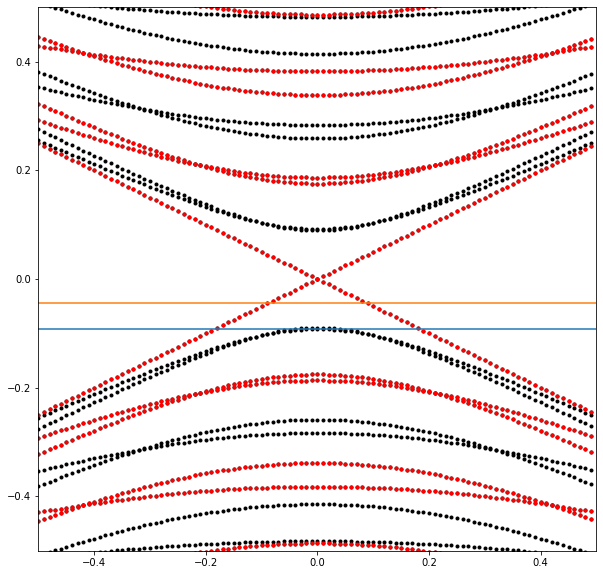

In [22]:
def plot_rel(h_fn, c='k.'):    
    for i in range(-50, 50):
        kvec = i / 100.0
        H = h_fn(kvec=kvec)
        evals, _ = tf.linalg.eigh(H)
        num_states = evals.shape[0]
        plt.plot([kvec]*num_states, tf.math.real(evals).numpy(), c)
        
plt.figure(figsize=(10, 10))
plot_rel(hamiltonian_fn)
plot_rel(hamiltonian_small_fn, 'r.')

plt.plot(np.linspace(-0.5, 0.5, 100), [-0.09201917]*100)
plt.plot(np.linspace(-0.5, 0.5, 100), [-0.04499724]*100)
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

## Search for optimial scaling parameters 

In [24]:
for i in tqdm(range(300)):
    loss, gradients = compute_gradients(num_evals, hamiltonian_fn, hamiltonian_small_fn, h_params_small)
    optimizer.apply_gradients(zip(gradients, h_params_small))
    loss_history.append(loss.numpy())
    param_hist.append(h_params_small[0].numpy())
    param_hist2.append(h_params_small[1].numpy())

100%|██████████| 300/300 [00:04<00:00, 65.83it/s]


In [25]:
# plt.plot(loss_history)

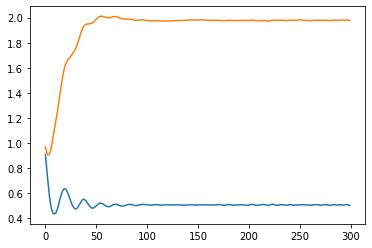

In [26]:
plt.plot(param_hist)
plt.plot(param_hist2)

In [27]:
h_params_small

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5026122>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9769996>]

## Compare band structre for scalled and original lattice

(-0.25, 0.25)

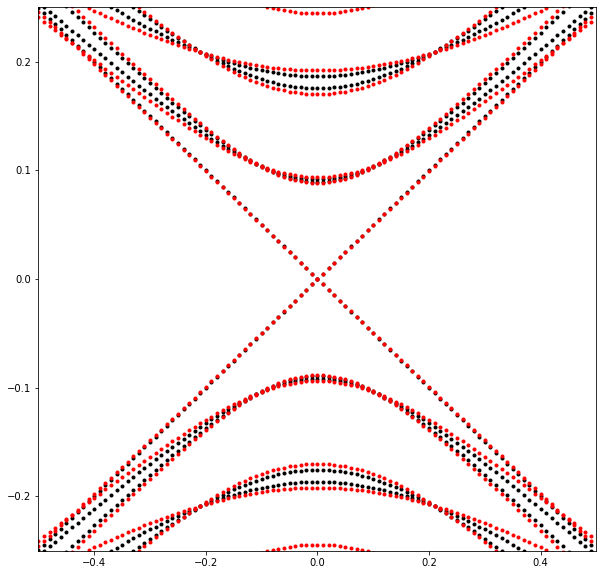

In [28]:
plt.figure(figsize=(10, 10))
plot_rel(hamiltonian_fn)
plot_rel(hamiltonian_small_fn, 'r.')
plt.xlim([-0.5, 0.5])
plt.ylim([-0.25, 0.25])

In [29]:
H = hamiltonian_fn(0.0)
evals, _ = tf.linalg.eigh(H)
H = hamiltonian_small_fn(0.0)
evals_small, _ = tf.linalg.eigh(H)

/home/mkk/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


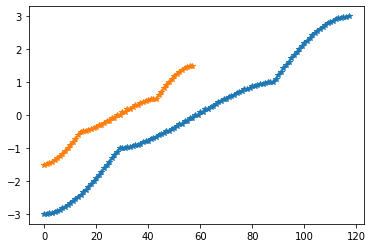

In [30]:
plt.plot(evals.numpy(), '*-')
plt.plot(evals_small.numpy(), '*-')
# plt.xlim([0, 10])
# plt.ylim([0, 1.25])

# Playing with bilayer graphene

Here lattice is constructed from H0 and Tau matrices which defines the lead band structure. These matrices has been generated from another program and here I just load them.

In [31]:
def create_hamiltonian(path, suffix, t0_init = 1.0, a0_init = 1.0):
    t0_var = tf.Variable(t0_init)
    a0_var = tf.Variable(a0_init)
    dtype = tf.complex64
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.float32)])
    def _fn(kvec):
        
        t0 = tf.complex(t0_var, 0.0)
        phase = tf.exp(-tf.complex(0.0, a0_var * kvec))
        
        H0 = np.loadtxt(f"{path}/H0{suffix}.txt")        
        H0 = tf.convert_to_tensor(H0, dtype=dtype)
        H0 = t0 * H0
        
        Tau = np.loadtxt(f"{path}/Tau{suffix}.txt") 
        Tau = tf.convert_to_tensor(Tau, dtype=dtype)
        
        S = t0 * phase * Tau
        S_h = tf.math.conj(tf.transpose(S))        
        
        return H0 + S + S_h
    
    return _fn, [t0_var, a0_var]

In [32]:
num_evals = 2
hamiltonian_fn, h_params = create_hamiltonian("lattices/graphen/", "_big")
hamiltonian_small_fn, h_params_small = create_hamiltonian("lattices/graphen/", "", a0_init=2.0, t0_init=0.5)

optimizer = tf.keras.optimizers.Adam(0.1, beta_1=0.9, beta_2=0.995, epsilon=0.0001)
loss_history = []
param_hist = []
param_hist2 = []

In [33]:
h_params

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>]

In [34]:
h_params_small

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>]

In [35]:

def plot_rel(h_fn, c='k.', scale=2/50):    
    for k, i in enumerate(range(-50, 50)):
        if k % 20 == 0:
            print(f"Computing: [{k+1}/100]")
        kvec = i * scale
        H = h_fn(kvec=kvec)
        evals, _ = tf.linalg.eigh(H)
        num_states = evals.shape[0]
        plt.plot([kvec]*num_states, tf.math.real(evals).numpy(), c)

Initial band structures

Computing: [1/100]
Computing: [21/100]
Computing: [41/100]
Computing: [61/100]
Computing: [81/100]
Computing: [1/100]
Computing: [21/100]
Computing: [41/100]
Computing: [61/100]
Computing: [81/100]


(-0.5, 0.5)

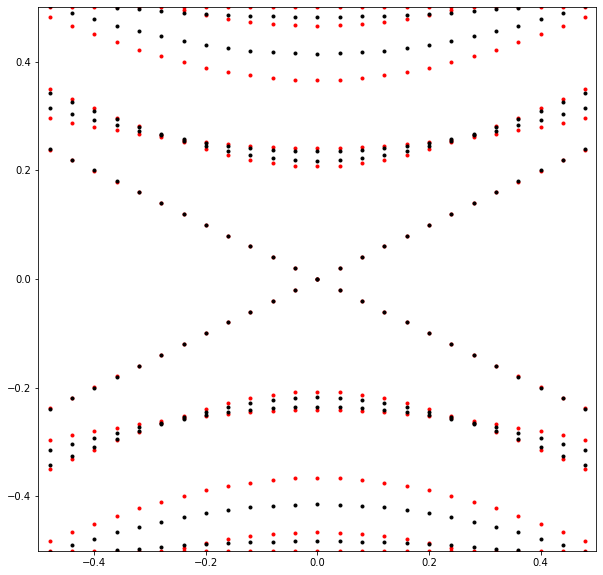

In [36]:
plt.figure(figsize=(10, 10))

plot_rel(hamiltonian_small_fn, 'r.')
plot_rel(hamiltonian_fn)

plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

In [36]:
loss, gradients = compute_gradients(num_evals, hamiltonian_fn, hamiltonian_small_fn, h_params_small)

In [37]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.0038120782>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-7.668484e-05>]

In [38]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=3.909441e-05>

In [39]:
h_params_small

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>]

In [40]:
for i in tqdm(range(300)):
    loss, gradients = compute_gradients(num_evals, hamiltonian_fn, hamiltonian_small_fn, h_params_small)
    optimizer.apply_gradients(zip(gradients, h_params_small))
    loss_history.append(loss.numpy())
    param_hist.append(h_params_small[0].numpy())
    param_hist2.append(h_params_small[1].numpy())

100%|██████████| 300/300 [00:01<00:00, 248.54it/s]


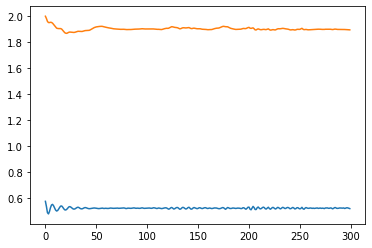

In [41]:
plt.plot(param_hist)
plt.plot(param_hist2)

## Optimized band structure

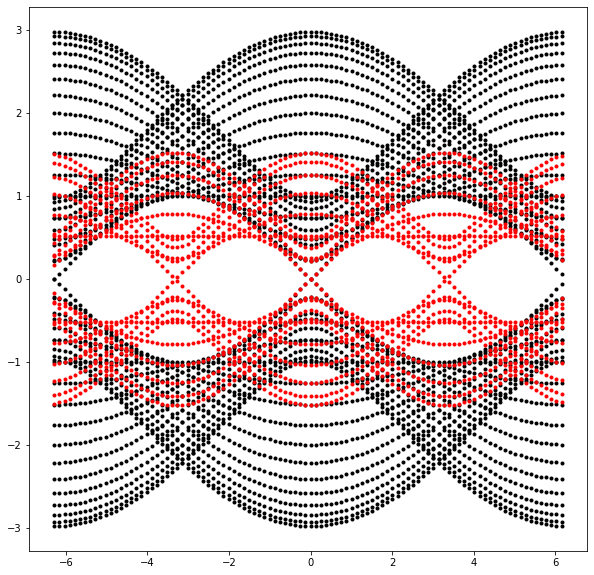

In [42]:
plt.figure(figsize=(10, 10))
plot_rel(hamiltonian_fn, scale=2*3.1415/50)
plot_rel(hamiltonian_small_fn, 'r.', scale=2*3.1415/50)
# plt.xlim([-0.75, 0.75])
# plt.ylim([-0.75, 0.75])

# Similar calculations but for much bigger lattices

In [37]:
def decompose_matrix(matrix, name = None, with_vars = True, val_to_var_map = None):
    matrices = []
    variables = []
    val_to_var = val_to_var_map or {}
    
    for k, v in enumerate(np.unique(matrix)):
        if abs(v) < 1e-5:
            continue
        
        masked_matrix = matrix * (matrix == v) / v
        if with_vars:
            np_v = float(v)
            if val_to_var_map is not None:
                if np_v in val_to_var_map:
                    v = val_to_var_map[np_v]
                else:
                    v = tf.Variable(v, name=f'{name}_{k}')
            else:                
                v = tf.Variable(v, name=f'{name}_{k}')
            variables.append(v)
            val_to_var[np_v] = v
            
        matrices.append(masked_matrix)
        
    return variables, matrices, val_to_var

In [44]:
m0 = np.loadtxt("lattices/blg/H0_BLG_small.txt")
vs, ms, val_to_var = decompose_matrix(m0, name="h0")
vs

[<tf.Variable 'h0_0:0' shape=() dtype=float64, numpy=-0.12>,
 <tf.Variable 'h0_2:0' shape=() dtype=float64, numpy=0.29>,
 <tf.Variable 'h0_3:0' shape=() dtype=float64, numpy=0.377>,
 <tf.Variable 'h0_4:0' shape=() dtype=float64, numpy=1.0>]

In [45]:
m0 = np.loadtxt("lattices/blg/Tau_BLG_small.txt")
vs, ms, val_to_var = decompose_matrix(m0, name="tau", val_to_var_map=val_to_var)

In [46]:
np.unique(m0)

array([-0.12,  0.  ,  0.29,  1.  ])

In [47]:
val_to_var

{-0.12: <tf.Variable 'h0_0:0' shape=() dtype=float64, numpy=-0.12>,
 0.29: <tf.Variable 'h0_2:0' shape=() dtype=float64, numpy=0.29>,
 0.377: <tf.Variable 'h0_3:0' shape=() dtype=float64, numpy=0.377>,
 1.0: <tf.Variable 'h0_4:0' shape=() dtype=float64, numpy=1.0>}

In [38]:
def create_hamiltonian(path, suffix, a0_init = 1.0):
    
    a0_var = tf.Variable(a0_init)
    dtype = tf.complex64
    
    h0_vars, _, val_to_var = decompose_matrix(np.loadtxt(f"{path}H0{suffix}.txt"), "H0")
    tau_vars, _, val_to_var = decompose_matrix(np.loadtxt(f"{path}Tau{suffix}.txt"), "Tau", val_to_var_map=val_to_var)
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.float32)])
    def _fn(kvec):
        
        phase = tf.exp(-tf.complex(0.0, a0_var * kvec))
        
        _, h0_matrices, _ = decompose_matrix(np.loadtxt(f"{path}H0{suffix}.txt"), with_vars=False)
        _, tau_matrices, _ = decompose_matrix(np.loadtxt(f"{path}Tau{suffix}.txt"), with_vars=False)
        
        H0 = tf.add_n([tf.cast(v * m, dtype=dtype) for v, m in zip(h0_vars, h0_matrices)])
        Tau = tf.add_n([tf.cast(v * m, dtype=dtype) for v, m in zip(tau_vars, tau_matrices)])
        print(H0)
        S = phase * Tau
        S_h = tf.math.conj(tf.transpose(S))        
        
        return H0 + S + S_h
    
    return _fn, list(val_to_var.values())


In [208]:
hamiltonian_fn, h_params = create_hamiltonian("lattices/2020/832at/", "")
hamiltonian_small_fn, h_params_small = create_hamiltonian("lattices/2020/424at/", "", a0_init=2.0)

In [209]:
h_params

[<tf.Variable 'H0_0:0' shape=() dtype=float64, numpy=-0.12>,
 <tf.Variable 'H0_2:0' shape=() dtype=float64, numpy=0.29>,
 <tf.Variable 'H0_3:0' shape=() dtype=float64, numpy=0.377>,
 <tf.Variable 'H0_4:0' shape=() dtype=float64, numpy=3.12>]

In [210]:
h_params_small

[<tf.Variable 'H0_0:0' shape=() dtype=float64, numpy=-0.12>,
 <tf.Variable 'H0_2:0' shape=() dtype=float64, numpy=0.29>,
 <tf.Variable 'H0_3:0' shape=() dtype=float64, numpy=0.377>,
 <tf.Variable 'H0_4:0' shape=() dtype=float64, numpy=3.12>]

In [211]:
scales = [1.0, 1.0, 1.0, 0.5]
[v.assign(v * s) for v, s in zip(h_params_small, scales)]
h_params_small

[<tf.Variable 'H0_0:0' shape=() dtype=float64, numpy=-0.12>,
 <tf.Variable 'H0_2:0' shape=() dtype=float64, numpy=0.29>,
 <tf.Variable 'H0_3:0' shape=() dtype=float64, numpy=0.377>,
 <tf.Variable 'H0_4:0' shape=() dtype=float64, numpy=1.56>]



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|1         | 1/100 [00:00<01:26,  1.14it/s]

  2%|2         | 2/100 [00:01<01:06,  1.47it/s]

  3%|3         | 3/100 [00:01<00:53,  1.83it/s]

  4%|4         | 4/100 [00:01<00:43,  2.21it/s]

  5%|5         | 5/100 [00:01<00:41,  2.28it/s]

  6%|6         | 6/100 [00:02<00:35,  2.61it/s]

  7%|7         | 7/100 [00:02<00:31,  2.94it/s]

  8%|8         | 8/100 [00:02<00:28,  3.25it/s]

  9%|9         | 9/100 [00:02<00:25,  3.51it/s]

 10%|#         | 10/100 [00:03<00:24,  3.69it/s]

 11%|#1        | 11/100 [00:03<00:23,  3.84it/s]

 12%|#2        | 12/100 [00:03<00:22,  3.96it/s]

 13%|#3        | 13/100 [00:03<00:21,  4.07it/s]

 14%|#4        | 14/100 [00:04<00:20,  4.15it/s]

 15%|#5        | 15/100 [00:04<00:20,  4.11it/s]

 16%|#6        | 16/100 [00:04<00:20,  4.10it/s]

 17%|#7        | 17/100 [00:04<00:19,  4.16it/s]

 18%|#8        | 18/100 [00:05<00:19,  4.18it/s]

 19%|#9        | 19/100 [00:05<00:19,  4.20it/s]

 20%|##        |

(-0.2, 0.2)

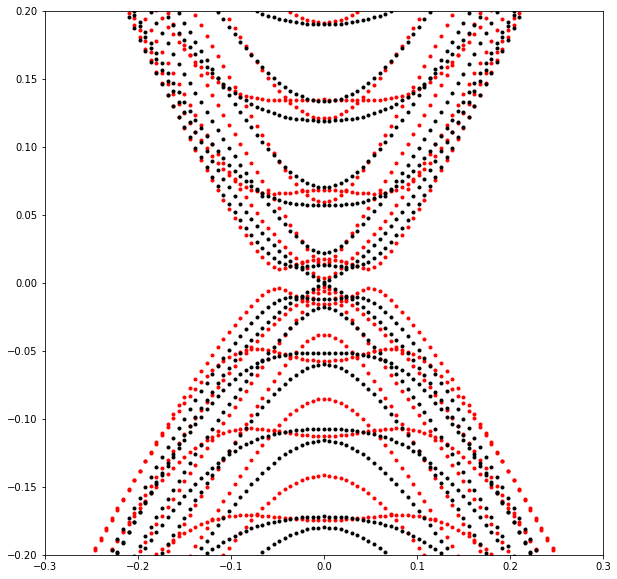

In [173]:
plt.figure(figsize=(10, 10))

plot_rel(hamiltonian_small_fn, 'r.', scale=0.3/50)
plot_rel(hamiltonian_fn, scale=0.3/50)

plt.xlim([-0.3, 0.3])
plt.ylim([-0.2, 0.2])

In [83]:
3.14159 / 10

0.31415899999999997

In [197]:
loss, gradients = compute_gradients(num_evals, hamiltonian_fn, hamiltonian_small_fn, h_params_small)

In [198]:
gradients

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.003201077242385608>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.001414445541602305>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0025565344920392974>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.0018538171621109711>]

In [199]:
h_params_small

[<tf.Variable 'H0_0:0' shape=() dtype=float64, numpy=-0.12>,
 <tf.Variable 'H0_2:0' shape=() dtype=float64, numpy=0.29>,
 <tf.Variable 'H0_3:0' shape=() dtype=float64, numpy=0.377>,
 <tf.Variable 'H0_4:0' shape=() dtype=float64, numpy=1.56>]

In [212]:
from collections import defaultdict
params_hist = defaultdict(list)
loss_history = []

In [213]:
optimizer = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.995, epsilon=0.0001)
# optimizer = tf.keras.optimizers.SGD(0.05, momentum=0.95)

In [214]:
h_params_small

[<tf.Variable 'H0_0:0' shape=() dtype=float64, numpy=-0.12>,
 <tf.Variable 'H0_2:0' shape=() dtype=float64, numpy=0.29>,
 <tf.Variable 'H0_3:0' shape=() dtype=float64, numpy=0.377>,
 <tf.Variable 'H0_4:0' shape=() dtype=float64, numpy=1.56>]

In [232]:
num_evals = 4
for i in tqdm(range(20)):
    loss, gradients = compute_gradients(
        num_evals, hamiltonian_fn, hamiltonian_small_fn, h_params_small, 
        batch_size=8, kvec_scale=3.14159 / 15
    )
    optimizer.apply_gradients(zip(gradients, h_params_small))
    # keep t0
    h_params_small[-1].assign(1.56)
    print(loss.numpy())
    loss_history.append(loss.numpy())
    for hp in h_params_small:
        params_hist[hp.name].append(hp.numpy())    






  0%|          | 0/20 [00:00<?, ?it/s]




  5%|▌         | 1/20 [00:06<02:06,  6.64s/it]

1.839744e-06







 10%|█         | 2/20 [00:12<01:56,  6.48s/it]

9.047952e-07







 15%|█▌        | 3/20 [00:18<01:47,  6.33s/it]

1.7362896e-06







 20%|██        | 4/20 [00:24<01:40,  6.26s/it]

1.4231737e-06







 25%|██▌       | 5/20 [00:31<01:33,  6.25s/it]

2.0066464e-06







 30%|███       | 6/20 [00:37<01:27,  6.24s/it]

8.7054525e-07







 35%|███▌      | 7/20 [00:43<01:21,  6.29s/it]

1.1542552e-06







 40%|████      | 8/20 [00:50<01:16,  6.34s/it]

6.3475545e-07







 45%|████▌     | 9/20 [00:56<01:10,  6.41s/it]

7.52986e-07







 50%|█████     | 10/20 [01:02<01:03,  6.34s/it]

1.0073444e-06







 55%|█████▌    | 11/20 [01:09<00:56,  6.33s/it]

8.825457e-07







 60%|██████    | 12/20 [01:15<00:50,  6.26s/it]

9.3559686e-07







 65%|██████▌   | 13/20 [01:21<00:43,  6.21s/it]

8.463134e-07







 70%|███████   | 14/20 [01:27<00:37,  6.27s/it]

7.174e-07







 75%|███████▌  | 15/20 [01:34<00:31,  6.26s/it]

9.392323e-07







 80%|████████  | 16/20 [01:40<00:25,  6.32s/it]

1.1873741e-06







 85%|████████▌ | 17/20 [01:46<00:18,  6.31s/it]

1.2814594e-06







 90%|█████████ | 18/20 [01:53<00:12,  6.35s/it]

1.0079696e-06







 95%|█████████▌| 19/20 [01:59<00:06,  6.36s/it]

7.984563e-07







100%|██████████| 20/20 [02:06<00:00,  6.30s/it]

1.1985541e-06


In [233]:
h_params_small

[<tf.Variable 'H0_0:0' shape=() dtype=float64, numpy=-0.05660952602747765>,
 <tf.Variable 'H0_2:0' shape=() dtype=float64, numpy=0.17003503239039272>,
 <tf.Variable 'H0_3:0' shape=() dtype=float64, numpy=0.370131579742057>,
 <tf.Variable 'H0_4:0' shape=() dtype=float64, numpy=1.56>]

In [234]:
h_params

[<tf.Variable 'H0_0:0' shape=() dtype=float64, numpy=-0.12>,
 <tf.Variable 'H0_2:0' shape=() dtype=float64, numpy=0.29>,
 <tf.Variable 'H0_3:0' shape=() dtype=float64, numpy=0.377>,
 <tf.Variable 'H0_4:0' shape=() dtype=float64, numpy=3.12>]

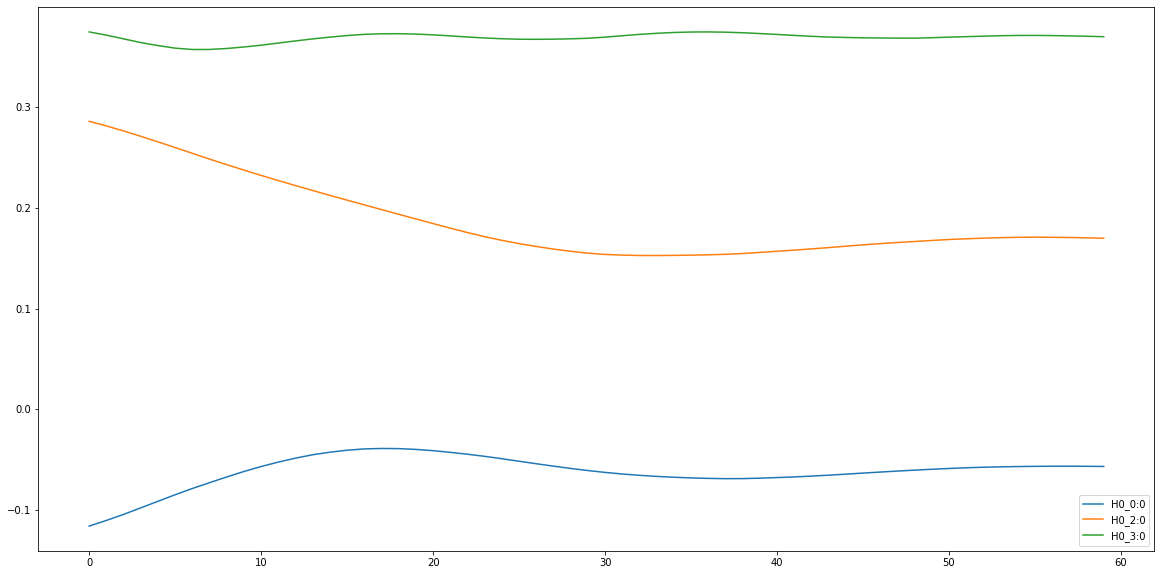

In [235]:
plt.figure(figsize=(20, 10))
for name, values in params_hist.items():
    if name != "H0_4:0":
        plt.plot(values, label=name)
plt.legend()

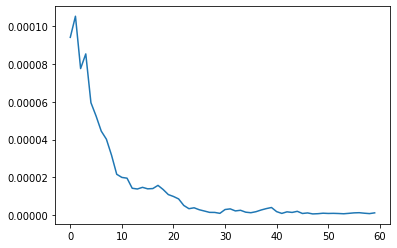

In [236]:
plt.plot(loss_history[-500:])

Computing: [1/100]
Computing: [21/100]
Computing: [41/100]
Computing: [61/100]
Computing: [81/100]
Computing: [1/100]
Computing: [21/100]
Computing: [41/100]
Computing: [61/100]
Computing: [81/100]


(-0.3, 0.3)

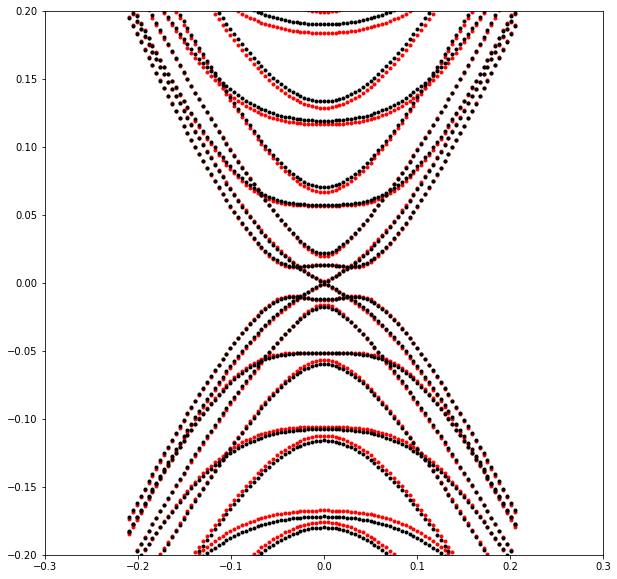

In [237]:
plt.figure(figsize=(10, 10))
plot_rel(hamiltonian_small_fn, 'r.', scale=3.14159/50/15)
plot_rel(hamiltonian_fn, scale=3.14159/50/15)
plt.ylim([-0.2, 0.2])
plt.xlim([-0.3, 0.3])

In [39]:
hamiltonian_fn, h_params = create_hamiltonian("lattices/2020/1660at/", "")
hamiltonian_small_fn, h_params_small = create_hamiltonian("lattices/2020/424at/", "", a0_init=4.0)

In [40]:
scales = [0.25, 0.25, 1.0, 0.25]
[v.assign(v * s) for v, s in zip(h_params_small, scales)]

[<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-0.03>,
 <tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.0725>,
 <tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.377>,
 <tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.78>]

In [52]:
def get_bands(h_fn, kvals = np.linspace(0, 0.2, 100)):
    kvec_energy = {}
    for kvec in tqdm(kvals):
        H = h_fn(kvec=kvec)
        evals, _ = tf.linalg.eigh(H)
        kvec_energy[kvec] = tf.math.real(evals).numpy()
    return kvec_energy

In [53]:
h_small_bands = get_bands(hamiltonian_small_fn)
h_bands = get_bands(hamiltonian_fn)

100%|██████████| 100/100 [28:11<00:00, 16.91s/it]


(0.0, 0.15)

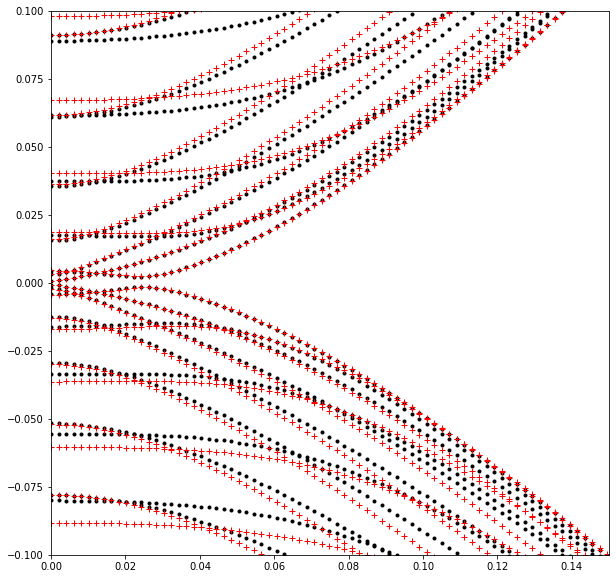

In [60]:
plt.figure(figsize=(10, 10))

for k, evals in h_small_bands.items():
    plt.plot([k]*evals.shape[0], evals, "k.")
for k, evals in h_bands.items():
    plt.plot([k]*evals.shape[0], evals, "r+")


plt.ylim([-0.1, 0.1])
plt.xlim([0.0, 0.15])